In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split

## Data

In [4]:
data = pd.read_csv("/Users/ben/Documents/GitHub/AdvancedMachineLearning/Data/WineData/cleansingWine.csv", low_memory=False)
data = data.drop("Unnamed: 0", axis = 1)
data.head()

,id,name,producer,nation,local1,local2,local3,local4,varieties1,varieties2,...,use,abv,degree,sweet,acidity,body,tannin,price,year,ml
0,137197,Altair,Altair,Chile,Rapel Valley,NaN,NaN,NaN,Cabernet Sauvignon,Carmenere,...,Table,14~15,17~19,SWEET1,ACIDITY4,BODY5,TANNIN4,220000,2014,750
1,137198,"Altair, Sideral",Altair,Chile,Rapel Valley,NaN,NaN,NaN,Cabernet Sauvignon,Merlot,...,Table,14~15,16~18,SWEET1,ACIDITY3,BODY4,TANNIN4,110000,2016,750
2,137199,Baron du Val Red,Baron du Val,France,NaN,NaN,NaN,NaN,Carignan,Cinsault,...,Table,11~12,15~17,SWEET2,ACIDITY3,BODY2,TANNIN2,0,0,750
3,137200,Baron du Val White,Baron du Val,France,NaN,NaN,NaN,NaN,Carignan,Ugni​ blanc,...,Table,11~12,9~11,SWEET1,ACIDITY3,BODY2,TANNIN1,0,0,750
4,137201,"Benziger, Cabernet Sauvignon",Benziger,USA,California,NaN,NaN,NaN,Cabernet Sauvignon,NaN,...,Table,13~14,17~19,SWEET1,ACIDITY3,BODY3,TANNIN4,0,2003,750


In [5]:
def remove_tilda(value):
    if "~" in value:
        values = value.split("~")
        avg = (float(value[0]) + float(value[-1]))/2
        return avg
    else:
        return float(value)

In [6]:
clean_data = data.drop(
    ["id", "name", "producer", "local3", "local4", "varieties2",
     "varieties3", "varieties4", "varieties5", "varieties6", "varieties7",
     "varieties8", "varieties9", "varieties10", "varieties11", "varieties12"], axis = 1)
clean_data = clean_data[(clean_data["price"] != 0) & (clean_data["year"] != 0)]
clean_data = clean_data.dropna(axis = 0)
clean_data["year"] = clean_data["year"].astype(str)
clean_data["abv"] = clean_data["abv"].apply(lambda x: remove_tilda(x))
clean_data["degree"] = clean_data["degree"].apply(lambda x: remove_tilda(x))
clean_data.reset_index(inplace=True, drop=True)
clean_data

,nation,local1,local2,varieties1,type,use,abv,degree,sweet,acidity,body,tannin,price,year,ml
0,France,Southern France,Languedoc Roussillon,Cabernet Sauvignon,Red,Table,2.5,4.5,SWEET1,ACIDITY3,BODY2,TANNIN3,19000,2017,750
1,France,Southern France,Languedoc Roussillon,Merlot,Red,Table,2.5,4.5,SWEET1,ACIDITY3,BODY3,TANNIN3,19000,2011,750
2,France,Bordeaux,Premieres Cotes de Bordeaux,Semillon,White,Dessert,13.0,1.5,SWEET2,ACIDITY4,BODY3,TANNIN1,18000,2009,750
3,France,Bordeaux,Medoc,Cabernet Sauvignon,Red,Table,2.0,4.5,SWEET1,ACIDITY4,BODY3,TANNIN3,32000,2015,750
4,France,Bordeaux,SaintEmilion,Merlot,Red,Table,2.0,4.5,SWEET1,ACIDITY3,BODY2,TANNIN2,42000,2010,750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4016,Italy,Toscana,Bolgheri,Cabernet Sauvignon,Red,Table,2.5,4.5,SWEET1,ACIDITY3,BODY3,TANNIN3,250000,2007,750
4017,USA,California,Riverside County,Sangiovese,Rose,"Appetizer, Table",2.5,4.0,SWEET2,ACIDITY3,BODY2,TANNIN1,195000,2013,750
4018,USA,California,Napa County,Cabernet Sauvignon,Red,Table,3.0,4.5,SWEET1,ACIDITY3,BODY4,TANNIN4,475000,2006,750
4019,the Republic of South Africa,Coastal Region,Paarl,Chardonnay,White,"Appetizer, Table",2.0,1.5,SWEET1,ACIDITY3,BODY2,TANNIN1,40000,2020,750


In [12]:
ct = ColumnTransformer(
    [
        ("dummify", preprocessing.OneHotEncoder(sparse_output=False, handle_unknown="error", drop = "first"), make_column_selector(dtype_include=object)),
        ("standardize", preprocessing.StandardScaler(), make_column_selector(dtype_include=np.number))
    ], remainder = "passthrough"
)

In [15]:
# Due to some weird errors I have ended up column transforming outside of the pipeline, I don't know why these occurred but this seemed to solve the issue.
X = clean_data.drop("price", axis = 1)
X = ct.fit_transform(X)
y = clean_data["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.25, random_state=1)

## Neural Networks

In [20]:
len(X_train[0])

453

In [93]:
#construct the model
inputs = keras.Input(shape=(453,))
x = layers.Dense(200, activation = 'relu')(inputs)
x = layers.Dense(100, activation = 'relu')(x)
x = layers.Dense(50, activation = 'relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="wine_model_2")

In [92]:
#construct the model
inputs = keras.Input(shape=(453,))
x1 = layers.Dense(400, activation = "relu")
x2 = layers.Dense(200, activation = 'relu')
x3 = layers.Dense(100, activation = 'relu')
x4 = layers.Dense(50, activation = "relu")
outputs = layers.Dense(1, activation = "sigmoid")
model = keras.Sequential(name="wine_model")
model.add(inputs)
model.add(x1)
model.add(x2)
model.add(x3)
model.add(x4)
model.add(outputs)
# model = keras.Model(inputs=inputs, outputs=outputs, name="wine_model")

In [87]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_65 (Dense)                │ (None, 400)            │       181,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,001 (1.09 MB)

 Trainable params: 287,001 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

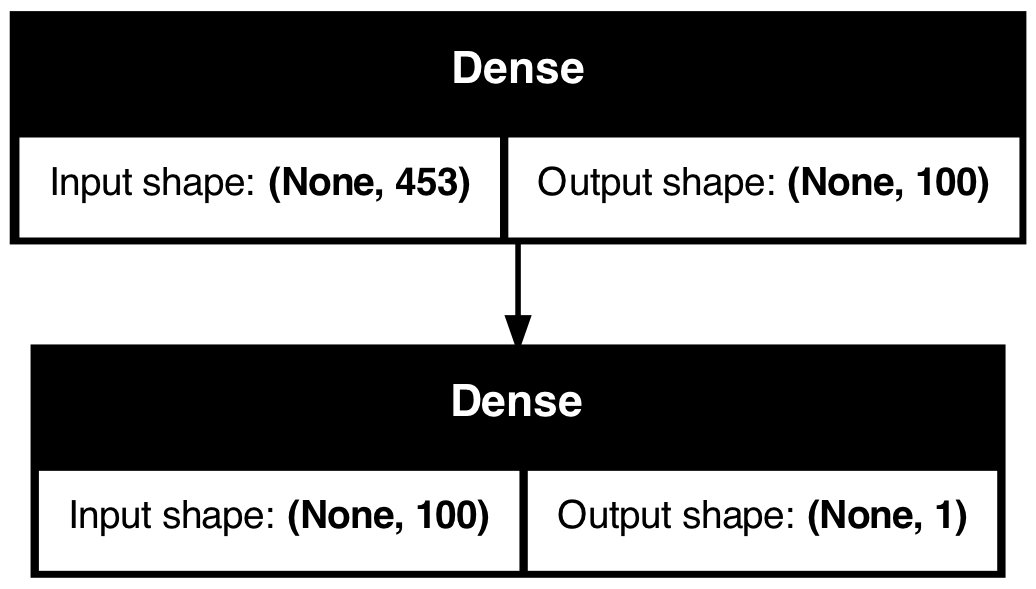

In [63]:
keras.utils.plot_model(model, show_shapes = True)

In [94]:
model.compile(
    # loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss = keras.losses.mae,
    optimizer=keras.optimizers.RMSprop(),
    metrics=["mean_absolute_error"],
)

history = model.fit(X_train, y_train, batch_size = 128, epochs=100, validation_split=.1)

scores = model.evaluate(X_test, y_test, verbose=2)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 181685.7031 - mean_absolute_error: 181685.7031 - val_loss: 140911.8906 - val_mean_absolute_error: 140911.8906
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 184138.5781 - mean_absolute_error: 184138.5781 - val_loss: 140911.8750 - val_mean_absolute_error: 140911.8750
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 187380.5156 - mean_absolute_error: 187380.5156 - val_loss: 140911.8750 - val_mean_absolute_error: 140911.8750
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 187905.4531 - mean_absolute_error: 187905.4531 - val_loss: 140911.8750 - val_mean_absolute_error: 140911.8750
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 190637.3906 - mean_absolute_error: 190637.3906 - val_loss: 140911.8750 - val_mean_absolute_error: 140911.8750
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 185886.0000 - mean_absolute_error: 185886.0000 - val_loss: 140911.8750 - val_mean_absolute_error: 14091